1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Half life: 183.12
Decay probability after an half life: 0.49977283596764477


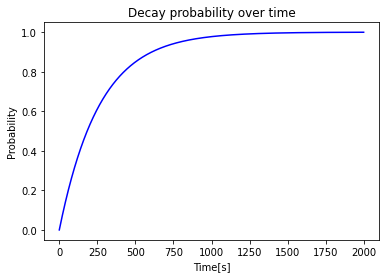

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import seaborn as sns

Tl_initial=1000
Pb_initial=0
step=1 #sec
half_life= 3.052*60 #in secondi
tot_time=2000
print('Half life:',half_life)
Tl_over_time=np.zeros(0)
Tl_over_time=np.append(Tl_over_time,Tl_initial)
Pb_over_time=np.zeros(0)
Pb_over_time=np.append(Pb_over_time,Pb_initial)
def prob_decay(t,mu=1/half_life):
    return 1-np.power(2,-mu*t)
#print(Tl_over_time)
x=np.arange(tot_time)
y=prob_decay(x)
plt.plot(x,y,'b')
plt.title('Decay probability over time')
plt.xlabel('Time[s]')
plt.ylabel('Probability')
print('Decay probability after an half life:',y[183])

498.33727952426756


Text(0.5, 1.0, 'Evolution over time')

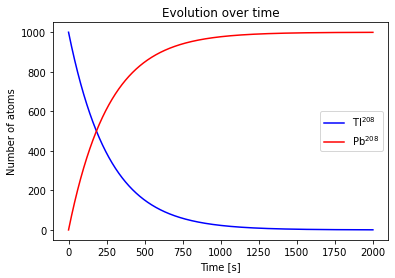

In [3]:
Tl_over_time=np.zeros(0)
Pb_over_time=np.zeros(0)
for i in range(tot_time):
    Tl_not_decayed =Tl_initial-Tl_initial*prob_decay(i)
    Pb_in_the_set= Pb_initial + Tl_initial*prob_decay(i)
    Tl_over_time= np.append(Tl_over_time, Tl_not_decayed)
    Pb_over_time= np.append(Pb_over_time, Pb_in_the_set)
#print(Tl_over_time.shape)
plt.plot(range(tot_time), Tl_over_time,'b',range(tot_time), Pb_over_time,'r')
#plt.plot(range(tot_time), Tl_over_time)
print(Tl_over_time[184])
plt.legend(('Tl$^{208}$', 'Pb$^{208}$'), loc='best')
plt.xlabel('Time [s]')
plt.ylabel('Number of atoms')
plt.title('Evolution over time')

Number of Tl samples after an half life: 498.33727952426756


Text(0, 0.5, 'Probability')

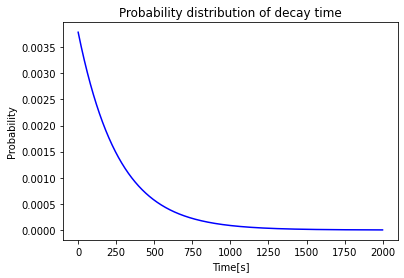

In [4]:
print('Number of Tl samples after an half life:',Tl_over_time[184])
half_life= 3.052*60
#tau= half_life/np.log(2)
def expon_pdf(t, mu=1/half_life):
    """PDF of exponential distribution."""
    return np.exp2(-mu*t)*np.log(2)*mu

def expon_cdf(t, tau=half_life):
    """CDF of exponetial distribution."""
    return 1 - np.exp2(-t/tau)

def expon_icdf(p, mu=1/half_life):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log2(1-p)/mu

plt.plot(np.arange(tot_time), expon_pdf(np.arange(tot_time)),'b')
plt.title('Probability distribution of decay time')
plt.xlabel('Time[s]')
plt.ylabel('Probability')

1000
527.0


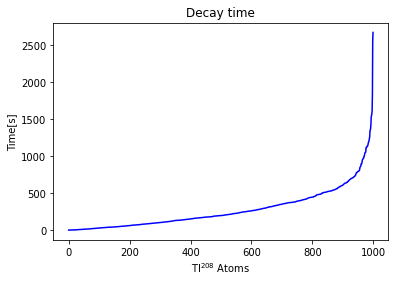

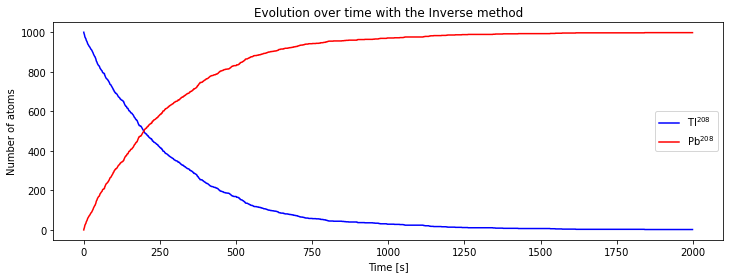

In [6]:
Tl_initial=1000
Pb_initial=0
half_life= 3.052*60 #in secondi
tot_time=2000
Tl_over_time=np.zeros(0)
Pb_over_time=np.zeros(0)
t_decay=np.zeros(0)
#genero i t_decay
for rn in range(Tl_initial):
    z = np.random.random()
    x = expon_icdf(z)
    t_decay=np.append(t_decay,x)

t_decay=np.sort(t_decay)
l=t_decay.shape[0]
print(l)
#conto decayed over time
for i in range(tot_time):
    count=0
    j=0
    while j<l:
        if t_decay[j]<=i:
            count +=1
        j +=1
    
    Tl_decayed=count
    Tl_over_time=np.append(Tl_over_time,Tl_initial-Tl_decayed)
    Pb_over_time=np.append(Pb_over_time,Tl_decayed)
plt.plot(np.arange(1000),t_decay,'b')
plt.title('Decay time')
plt.ylabel('Time[s]')
plt.xlabel('Tl$^{208}$ Atoms')
plt.figure(figsize=(12,4))
plt.plot(range(tot_time), Tl_over_time,'b',range(tot_time), Pb_over_time,'r')
plt.legend(('Tl$^{208}$', 'Pb$^{208}$'), loc='best')
plt.xlabel('Time [s]')
plt.ylabel('Number of atoms')
plt.title('Evolution over time with the Inverse method')
print(Tl_over_time[184])

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [7]:
import scipy.constants as sc
Z=79
E=7.7*10**6*sc.e
N_alfa= 10**6
std= sc.physical_constants['Bohr radius'][0]/100

# Box-Muller method
z = np.random.rand(N_alfa)
b = np.sqrt(-2*std**(2)*np.log(1-z))
const=Z*(sc.e)**2/(2*np.pi*sc.epsilon_0*E)
print(const)
theta = 2*np.arctan(const/b)
print('Fraction of particles that bounce back:',len(theta[theta>np.pi/2])/N_alfa)
sc.physical_constants['Bohr radius']

2.9547324472111997e-14
Fraction of particles that bounce back: 0.001609


(5.29177210903e-11, 'm', 8e-21)

3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

True integral from 0 to 2: 1.4514014971676978
Estimate of the absolute error on the result: 2.461256014552049e-07


c:\users\francesco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: IntegrationWarning: The maximum number of subdivisions (10000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  # Remove the CWD from sys.path while we load stuff.


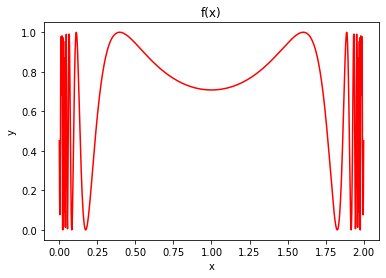

In [8]:
import scipy.integrate as integrate
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')
plt.title('f(x)')
plt.ylabel('y')
plt.xlabel('x')
I_true=integrate.quad(f,0,2,limit=10000)
print("True integral from 0 to 2:",I_true[0])
print('Estimate of the absolute error on the result:',I_true[1])

In [12]:
# Monte Carlo integration HIT_MISS
N=10000
count=0

for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2*count/N
print("Estimated integral with HIT MISS method:",I)
#print(np.random.random())
print("Error with hit miss:",np.abs(I_true[0]-I))
for i in range(N):
    x=2*np.random.random()
    values = np.append(values,f(x))
I_est=2*np.sum(values)/N
print("Estimsted integral with MEAN VALUE method:",I_est)
print("Error using mean value:",np.abs(I_est-I_true[0])) #this performs better

Estimated integral with HIT MISS method: 1.4578
Error with hit miss: 0.006398502832302144
Estimsted integral with MEAN VALUE method: 2.900447860791075
Error using mean value: 1.4490463636233772


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [13]:
def fun(x):
    x_squared=x**2
    f = np.sum(x_squared)
    #return f
    if f<=1:
        return 1
    else: 
        return 0


np.sum(fun(np.array([1,2,0])))
fun_values=np.zeros(N)
print(fun_values.shape)

(10000,)


In [14]:
N=10000
n_dim=2
values = 2*np.random.random(size=(N, n_dim))-1
values.shape
fun_values=np.zeros(N)
A=np.pi
for i in range(values.shape[0]):
    fun_values[i]=fun(values[i,:])

I_est=2**n_dim*np.sum(fun_values)/N
print("True Area:", A)
print("Estimated integral with 2 dimensions:", I_est)
print('Error:',np.abs(A-I_est))

True Area: 3.141592653589793
Estimated integral with 2 dimensions: 3.0916
Error: 0.04999265358979299


In [15]:
N=10000
n_dim=10
values = 2*np.random.random(size=(N, n_dim))-1
A_iper=np.pi**5/120
values.shape
fun_values=np.zeros(N)
for i in range(values.shape[0]):
    fun_values[i]=fun(values[i,:])
#print(fun_values)
I_est=2**n_dim*np.sum(fun_values)/N
print("True Area:", A_iper)
print("Estimated integral with 10 dimensions:", I_est)
print('Error:',np.abs(A_iper-I_est))

True Area: 2.550164039877345
Estimated integral with 10 dimensions: 2.4576
Error: 0.0925640398773453


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [16]:
def f(x):
    return x**(-0.5)/(np.exp(x)+1)

def w(x):
    """PDF of exponential distribution."""
    return x**(-0.5)
#NON SERVONO PER L'ESERCIZIO
def weight_cdf(x):
    """CDF of exponetial distribution."""
    return 2*x**0.5

def weight_icdf(p):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return (p/2)**2



#WITH IMPORTANCE SAMPLING
N=10000
x=np.random.random(N)
#integral of w(x) in the domain
V=2 
I_est=1/N*np.sum(f(x)/w(x))*V
I_true=integrate.quad(f,0,1)
print('True integral:',I_true)
print("Estimated integral:", I_est)
print('Error:',np.abs(I_true[0]-I_est))

True integral: (0.8389329600133838, 1.9939605522267811e-13)
Estimated integral: 0.7602625752886719
Error: 0.07867038472471188


In [17]:
#WITH MEAN VALUE METHOD
x=np.random.random(N)
#integral of w(x) in the domain
V=1
I_est=1/N*np.sum(f(x))*V
I_true=integrate.quad(f,0,1)
print('True integral:',I_true)
print("Estimated integral:", I_est)
print('Error:',np.abs(I_true[0]-I_est))

True integral: (0.8389329600133838, 1.9939605522267811e-13)
Estimated integral: 0.8422581533465832
Error: 0.003325193333199361
